## DS 6120, 6130: Capstone A and B
## Identifying Complex Metadata Relationships to Objects using Natural Language Processing and Image Classification
## Authors: Anand Rajan, Benjamin Wilke, and Tej Tenmattam

---

# 1. Download the dataset and import the required libraries

In [ ]:
# Get the Flickr text dataset
#!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [ ]:
# Get the Flickr photos dataset
#!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

In [ ]:
# Download GloVe: Global Vectors for Word Representation
#!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
# Unzip the downloaded files
#!unzip Flickr8k_Dataset.zip
#!unzip Flickr8k_text.zip
#!unzip glove.6B.zip

In [1]:
# Import the necessary libraries for this project

import string
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from os import listdir
from os import path
from numpy import array
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu
from pickle import dump
from pickle import load
#from keras.applications.vgg16 import VGG16
#from keras.applications.vgg16 import preprocess_input
#from keras.applications.vgg19 import VGG19
#from keras.applications.vgg19 import preprocess_input
#from keras.applications.resnet50 import ResNet50
#from keras.applications.resnet50 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.preprocessing import image
from keras import Input, layers
from keras import optimizers
from time import time
from PIL import Image

import json


Using TensorFlow backend.


In [ ]:
# Capture the time
start = time()

# 2. Data Preparation

In [2]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
    
# Loads raw COCO Annotation JSON, returns as dictionary
def load_doc_json(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return json.loads(text)

In [ ]:
train_doc = load_doc_json('annotations/captions_train2017.json')
val_doc = load_doc_json('annotations/captions_val2017.json')

train_doc.keys()

In [ ]:
def load_descriptions(doc):
    mapping = {}
    for image in doc['images']:
        temp_caption_list = list()                           #<-- init our caption list, emptying it from last iteration
        image_id = image['file_name'].split('.')[0]          #<-- get filename for key
        lookup_id = image['id']                              #<-- get truncated ID for annotation lookup
        for caption in doc['annotations']:                   #<-- loop through captions to find matches
            if caption['image_id'] == lookup_id:
                temp_caption_list.append(caption['caption']) #<-- add each caption to list
        if image_id not in mapping:                          #<-- add our caption list to our dict()
            mapping[image_id] = temp_caption_list         
    return mapping
                           

In [ ]:
train_descriptions = load_descriptions(train_doc)
val_descriptions = load_descriptions(val_doc)

In [ ]:
print("Length Train Descriptions: {}".format(len(train_descriptions)))
print("Length Validation Descriptions: {}".format(len(val_descriptions)))

In [ ]:
# The descriptions are tokenized which mean that each token is comprised of words separated by white space and also punctuation are separated as tokens, such as periods (‘.’) and apostrophes.
# For data cleaning we can change the case of all tokens to lowercase.
# Remove all punctuation from tokens.
# Remove all tokens that contain one or fewer characters.
def clean_descriptions(descriptions):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    for _, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [re_punc.sub('', w) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

In [ ]:
# We will now convert the loaded descriptions into a vocabulary of words. Takes a list to accomadate for train/val
def to_vocabulary(descriptions):
    all_desc = set()                         #<-- build a list of all description strings
    for each in descriptions:
        for key in each.keys():
            [all_desc.update(d.split()) for d in each[key]]     #<-- splits description into tokens, only adds new to set()
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary([train_descriptions, val_descriptions])
print('Vocabulary Size: %d' % len(vocabulary))

In [ ]:
# We will now save the clean text to file for later use by our model.
# Each line will contain the image identifier followed by the clean description.
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(train_descriptions, 'train_COCOdescriptions.txt')
save_descriptions(val_descriptions, 'val_COCOdescriptions.txt')

# 3. Extract image features using Inception V3

In [5]:
# Run this code cell for Inception only

# We will use the pre-trained CNN models to extract the features from the images
# We will remove the last layer from the loaded model, as Inception is a model used to predict a classification for a photo. 
# We are not interested in classifying images, but we are interested in the internal representation of the photo right before a classification is made. 
# These are the features that the model has extracted from the photo.

# Run this code cell for Inception only

# We will use the pre-trained CNN models to extract the features from the images
# We will remove the last layer from the loaded model, as Inception is a model used to predict a classification for a photo. 
# We are not interested in classifying images, but we are interested in the internal representation of the photo right before a classification is made. 
# These are the features that the model has extracted from the photo.

# extract features from each photo in the directory
def extract_features_wilke(directory):
    # load the model
    model = InceptionV3(weights='imagenet')
    model = Model(model.input, model.layers[-2].output)

    #model.summary()
    # extract features from each photo
    features = dict()
    for idx, name in enumerate(listdir(directory)):
        # load an image from file
        filename = path.join(directory, name)
        image = load_img(filename, target_size=(299, 299))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the Inception model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        if idx % 2500:
            print("{} Completed".format(idx))
    return features

In [6]:
# extract features from train images
train_features = extract_features_wilke('train2017')
print('Train 2017 Extracted Features: %d' % len(train_features))

Train 2017 Extracted Features: 118287


In [4]:
# extract features from validation images
val_features = extract_features_wilke('val2017')
print('Validation 2017 Extracted Features: %d' % len(val_features))

>000000521956.jpg
>000000415882.jpg
>000000073702.jpg
>000000062692.jpg
>000000448410.jpg
>000000147498.jpg
>000000011197.jpg
>000000475572.jpg
>000000357737.jpg
>000000429530.jpg
>000000091615.jpg
>000000002532.jpg
>000000226111.jpg
>000000042178.jpg
>000000065485.jpg
>000000088432.jpg
>000000054967.jpg
>000000528399.jpg
>000000361919.jpg
>000000297022.jpg
>000000143931.jpg
>000000363461.jpg
>000000263860.jpg
>000000312552.jpg
>000000319935.jpg
>000000565962.jpg
>000000508639.jpg
>000000324614.jpg
>000000489305.jpg
>000000492968.jpg
>000000458109.jpg
>000000336209.jpg
>000000076468.jpg
>000000322895.jpg
>000000404568.jpg
>000000439773.jpg
>000000353180.jpg
>000000357238.jpg
>000000230008.jpg
>000000372317.jpg
>000000376442.jpg
>000000437392.jpg
>000000012062.jpg
>000000391140.jpg
>000000377946.jpg
>000000497599.jpg
>000000280918.jpg
>000000032285.jpg
>000000499768.jpg
>000000148508.jpg
>000000107087.jpg
>000000109976.jpg
>000000005477.jpg
>000000460967.jpg
>000000476810.jpg
>000000050

>000000300659.jpg
>000000122046.jpg
>000000144798.jpg
>000000316404.jpg
>000000011760.jpg
>000000437514.jpg
>000000296634.jpg
>000000350054.jpg
>000000129812.jpg
>000000019042.jpg
>000000216636.jpg
>000000488710.jpg
>000000256192.jpg
>000000227898.jpg
>000000070158.jpg
>000000535156.jpg
>000000474293.jpg
>000000279769.jpg
>000000011149.jpg
>000000350003.jpg
>000000552612.jpg
>000000108026.jpg
>000000032861.jpg
>000000303908.jpg
>000000119911.jpg
>000000172648.jpg
>000000453302.jpg
>000000301061.jpg
>000000313130.jpg
>000000459396.jpg
>000000522638.jpg
>000000407083.jpg
>000000464786.jpg
>000000491683.jpg
>000000066706.jpg
>000000568710.jpg
>000000151662.jpg
>000000090062.jpg
>000000512476.jpg
>000000462614.jpg
>000000262895.jpg
>000000497568.jpg
>000000364102.jpg
>000000578545.jpg
>000000236730.jpg
>000000102820.jpg
>000000486438.jpg
>000000176857.jpg
>000000263425.jpg
>000000286708.jpg
>000000449909.jpg
>000000478286.jpg
>000000089271.jpg
>000000489091.jpg
>000000286507.jpg
>000000060

>000000361551.jpg
>000000320664.jpg
>000000449579.jpg
>000000221872.jpg
>000000008211.jpg
>000000034417.jpg
>000000145620.jpg
>000000098716.jpg
>000000568439.jpg
>000000167902.jpg
>000000533536.jpg
>000000272364.jpg
>000000041635.jpg
>000000186282.jpg
>000000528524.jpg
>000000463647.jpg
>000000290771.jpg
>000000140439.jpg
>000000076731.jpg
>000000505789.jpg
>000000257865.jpg
>000000186624.jpg
>000000504635.jpg
>000000352900.jpg
>000000306733.jpg
>000000331075.jpg
>000000372203.jpg
>000000174482.jpg
>000000157807.jpg
>000000092177.jpg
>000000458410.jpg
>000000158744.jpg
>000000101787.jpg
>000000559547.jpg
>000000168619.jpg
>000000229601.jpg
>000000322352.jpg
>000000142324.jpg
>000000131379.jpg
>000000430377.jpg
>000000119516.jpg
>000000497344.jpg
>000000180296.jpg
>000000458755.jpg
>000000320490.jpg
>000000416745.jpg
>000000032901.jpg
>000000422836.jpg
>000000389804.jpg
>000000070774.jpg
>000000375015.jpg
>000000499266.jpg
>000000430875.jpg
>000000198510.jpg
>000000442993.jpg
>000000474

>000000500270.jpg
>000000423519.jpg
>000000389451.jpg
>000000265777.jpg
>000000491090.jpg
>000000480842.jpg
>000000195165.jpg
>000000008629.jpg
>000000392818.jpg
>000000471567.jpg
>000000128051.jpg
>000000335328.jpg
>000000046497.jpg
>000000102644.jpg
>000000197004.jpg
>000000308328.jpg
>000000016439.jpg
>000000396580.jpg
>000000001268.jpg
>000000468233.jpg
>000000523175.jpg
>000000292446.jpg
>000000139883.jpg
>000000149568.jpg
>000000124975.jpg
>000000196759.jpg
>000000287527.jpg
>000000213255.jpg
>000000263969.jpg
>000000511384.jpg
>000000053909.jpg
>000000379800.jpg
>000000206411.jpg
>000000353027.jpg
>000000011813.jpg
>000000195842.jpg
>000000327306.jpg
>000000359677.jpg
>000000155443.jpg
>000000329080.jpg
>000000003501.jpg
>000000112798.jpg
>000000467511.jpg
>000000017029.jpg
>000000256941.jpg
>000000319100.jpg
>000000568147.jpg
>000000076416.jpg
>000000126592.jpg
>000000134096.jpg
>000000118921.jpg
>000000398237.jpg
>000000210520.jpg
>000000491216.jpg
>000000341719.jpg
>000000327

>000000543300.jpg
>000000196009.jpg
>000000577864.jpg
>000000483531.jpg
>000000525247.jpg
>000000533206.jpg
>000000425390.jpg
>000000103548.jpg
>000000501368.jpg
>000000570456.jpg
>000000148662.jpg
>000000304560.jpg
>000000266892.jpg
>000000389812.jpg
>000000316054.jpg
>000000463037.jpg
>000000188592.jpg
>000000176701.jpg
>000000382009.jpg
>000000566524.jpg
>000000019924.jpg
>000000431693.jpg
>000000201934.jpg
>000000028452.jpg
>000000222299.jpg
>000000050811.jpg
>000000263068.jpg
>000000066561.jpg
>000000330818.jpg
>000000173057.jpg
>000000323895.jpg
>000000505638.jpg
>000000476770.jpg
>000000272136.jpg
>000000425226.jpg
>000000424551.jpg
>000000479248.jpg
>000000293044.jpg
>000000476258.jpg
>000000098287.jpg
>000000341681.jpg
>000000424521.jpg
>000000257370.jpg
>000000242678.jpg
>000000176037.jpg
>000000085478.jpg
>000000214720.jpg
>000000293804.jpg
>000000512248.jpg
>000000468332.jpg
>000000525155.jpg
>000000154705.jpg
>000000261706.jpg
>000000226154.jpg
>000000453708.jpg
>000000542

>000000311295.jpg
>000000524108.jpg
>000000240023.jpg
>000000311180.jpg
>000000459887.jpg
>000000224093.jpg
>000000521540.jpg
>000000216516.jpg
>000000325114.jpg
>000000544519.jpg
>000000370270.jpg
>000000058705.jpg
>000000506310.jpg
>000000465675.jpg
>000000091495.jpg
>000000142971.jpg
>000000008844.jpg
>000000457262.jpg
>000000217400.jpg
>000000127624.jpg
>000000319184.jpg
>000000230450.jpg
>000000043737.jpg
>000000181542.jpg
>000000381971.jpg
>000000365766.jpg
>000000399205.jpg
>000000383842.jpg
>000000091619.jpg
>000000179898.jpg
>000000050844.jpg
>000000517056.jpg
>000000110784.jpg
>000000386352.jpg
>000000134112.jpg
>000000231549.jpg
>000000552775.jpg
>000000292997.jpg
>000000358427.jpg
>000000221281.jpg
>000000052412.jpg
>000000530975.jpg
>000000140640.jpg
>000000249219.jpg
>000000057150.jpg
>000000329614.jpg
>000000190236.jpg
>000000351530.jpg
>000000032817.jpg
>000000351823.jpg
>000000013291.jpg
>000000343561.jpg
>000000245651.jpg
>000000427655.jpg
>000000235241.jpg
>000000037

>000000142472.jpg
>000000223789.jpg
>000000554002.jpg
>000000018837.jpg
>000000441543.jpg
>000000309655.jpg
>000000069224.jpg
>000000276284.jpg
>000000205834.jpg
>000000225946.jpg
>000000372466.jpg
>000000366178.jpg
>000000367228.jpg
>000000203317.jpg
>000000481390.jpg
>000000463842.jpg
>000000098497.jpg
>000000187513.jpg
>000000485237.jpg
>000000485895.jpg
>000000572956.jpg
>000000335450.jpg
>000000215778.jpg
>000000161861.jpg
>000000422886.jpg
>000000369370.jpg
>000000450488.jpg
>000000573094.jpg
>000000313034.jpg
>000000005001.jpg
>000000209753.jpg
>000000453001.jpg
>000000093154.jpg
>000000515579.jpg
>000000371749.jpg
>000000357903.jpg
>000000327601.jpg
>000000530466.jpg
>000000350388.jpg
>000000376278.jpg
>000000247838.jpg
>000000221155.jpg
>000000466835.jpg
>000000027932.jpg
>000000157098.jpg
>000000402433.jpg
>000000580418.jpg
>000000133343.jpg
>000000521509.jpg
>000000547144.jpg
>000000357081.jpg
>000000481404.jpg
>000000565776.jpg
>000000080949.jpg
>000000082688.jpg
>000000475

>000000504439.jpg
>000000578967.jpg
>000000129322.jpg
>000000121242.jpg
>000000034071.jpg
>000000189078.jpg
>000000207844.jpg
>000000407298.jpg
>000000000776.jpg
>000000311190.jpg
>000000078170.jpg
>000000173383.jpg
>000000389532.jpg
>000000201072.jpg
>000000473118.jpg
>000000157756.jpg
>000000311081.jpg
>000000087476.jpg
>000000113867.jpg
>000000240940.jpg
>000000148730.jpg
>000000170278.jpg
>000000528977.jpg
>000000453040.jpg
>000000417779.jpg
>000000293474.jpg
>000000109441.jpg
>000000345261.jpg
>000000255824.jpg
>000000450439.jpg
>000000159977.jpg
>000000466256.jpg
>000000159282.jpg
>000000217285.jpg
>000000352684.jpg
>000000562197.jpg
>000000556498.jpg
>000000509131.jpg
>000000309452.jpg
>000000486104.jpg
>000000456865.jpg
>000000104803.jpg
>000000136334.jpg
>000000089045.jpg
>000000222455.jpg
>000000441247.jpg
>000000539962.jpg
>000000371529.jpg
>000000405195.jpg
>000000377575.jpg
>000000565853.jpg
>000000227482.jpg
>000000193429.jpg
>000000419312.jpg
>000000172330.jpg
>000000529

>000000542127.jpg
>000000125778.jpg
>000000199055.jpg
>000000069795.jpg
>000000191288.jpg
>000000527427.jpg
>000000470779.jpg
>000000484893.jpg
>000000447200.jpg
>000000386134.jpg
>000000226903.jpg
>000000352584.jpg
>000000211120.jpg
>000000465806.jpg
>000000541634.jpg
>000000334006.jpg
>000000320425.jpg
>000000267434.jpg
>000000195918.jpg
>000000125850.jpg
>000000191761.jpg
>000000127987.jpg
>000000079014.jpg
>000000213086.jpg
>000000450303.jpg
>000000394677.jpg
>000000128675.jpg
>000000019402.jpg
>000000394611.jpg
>000000401862.jpg
>000000576052.jpg
>000000052891.jpg
>000000499622.jpg
>000000469192.jpg
>000000398652.jpg
>000000255912.jpg
>000000382122.jpg
>000000560266.jpg
>000000383443.jpg
>000000154000.jpg
>000000129416.jpg
>000000355169.jpg
>000000217872.jpg
>000000547336.jpg
>000000097230.jpg
>000000396729.jpg
>000000456559.jpg
>000000095843.jpg
>000000050326.jpg
>000000029397.jpg
>000000028809.jpg
>000000457078.jpg
>000000257896.jpg
>000000482719.jpg
>000000432468.jpg
>000000052

>000000274411.jpg
>000000006614.jpg
>000000129945.jpg
>000000551780.jpg
>000000044877.jpg
>000000085576.jpg
>000000384136.jpg
>000000064868.jpg
>000000018491.jpg
>000000462904.jpg
>000000226058.jpg
>000000447088.jpg
>000000359219.jpg
>000000064574.jpg
>000000507667.jpg
>000000469828.jpg
>000000323151.jpg
>000000443426.jpg
>000000283785.jpg
>000000295797.jpg
>000000373382.jpg
>000000372349.jpg
>000000572678.jpg
>000000314541.jpg
>000000035279.jpg
>000000465836.jpg
>000000062808.jpg
>000000293300.jpg
>000000157928.jpg
>000000264335.jpg
>000000548780.jpg
>000000554579.jpg
>000000109992.jpg
>000000426372.jpg
>000000507015.jpg
>000000227478.jpg
>000000563653.jpg
>000000231831.jpg
>000000094614.jpg
>000000570756.jpg
>000000399296.jpg
>000000034452.jpg
>000000284991.jpg
>000000173044.jpg
>000000576654.jpg
>000000167159.jpg
>000000376625.jpg
>000000329827.jpg
>000000002923.jpg
>000000270402.jpg
>000000221291.jpg
>000000189828.jpg
>000000059044.jpg
>000000031118.jpg
>000000149770.jpg
>000000472

>000000238039.jpg
>000000244750.jpg
>000000302452.jpg
>000000009891.jpg
>000000140987.jpg
>000000275198.jpg
>000000460683.jpg
>000000522889.jpg
>000000357459.jpg
>000000462576.jpg
>000000257084.jpg
>000000163682.jpg
>000000383289.jpg
>000000283038.jpg
>000000239773.jpg
>000000201676.jpg
>000000353518.jpg
>000000407646.jpg
>000000229747.jpg
>000000569700.jpg
>000000229849.jpg
>000000452793.jpg
>000000116206.jpg
>000000281032.jpg
>000000088269.jpg
>000000370818.jpg
>000000065455.jpg
>000000161128.jpg
>000000066523.jpg
>000000333237.jpg
>000000192964.jpg
>000000455448.jpg
>000000179487.jpg
>000000094336.jpg
>000000141821.jpg
>000000368900.jpg
>000000031269.jpg
>000000411665.jpg
>000000448076.jpg
>000000484404.jpg
>000000361621.jpg
>000000382696.jpg
>000000321557.jpg
>000000004395.jpg
>000000454067.jpg
>000000447187.jpg
>000000136715.jpg
>000000351609.jpg
>000000156292.jpg
>000000518770.jpg
>000000356248.jpg
>000000025424.jpg
>000000235857.jpg
>000000350833.jpg
>000000151657.jpg
>000000117

In [7]:
# save the extracted features to files
dump(train_features, open('train_features_inceptionV3COCO.pkl', 'wb'))
dump(val_features, open('val_features_inceptionV3COCO.pkl', 'wb'))

In [ ]:
# load features from file
train_features = load(open('train_features_inceptionV3COCO.pkl', 'rb'))
val_features = load(open('val_features_inceptionV3COCO.pkl', 'rb'))

# 4. Load prepared data

In [8]:
# Below function loads the cleaned text descriptions from file
# Adds startseq and endseq to each description as they are loaded.
def load_clean_descriptions(filename):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):                                   #<-- split @ new line
        tokens = line.split()                                      #<-- split whole line on spaces
        image_id, image_desc = tokens[0], tokens[1:]               #<-- split id from description
        if image_id not in descriptions:                           #<-- if image_id doesn't already exist
            descriptions[image_id] = list()                        #<-- then create a key for it and initialize a list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'  #<-- reform description and wrap in tokens
            descriptions[image_id].append(desc)                    #<-- add formed description at key
    return descriptions

In [9]:
# load training descriptions
train_descriptions = load_clean_descriptions('train_COCOdescriptions.txt')
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=118287


In [10]:
# load validation descriptions
val_descriptions = load_clean_descriptions('val_COCOdescriptions.txt')
print('Descriptions: val=%d' % len(val_descriptions))

Descriptions: val=5000


# 5. Encode the data

In [11]:
# Next, we will have to encode to numbers the description text before we can present it to the model as an input
# The first step in encoding the data is to create a mapping from words to unique integer values.
# convert a dictionary of clean descriptions to a list of descriptions
# basically adds each description from each image to each other to make one long list of all descriptions strings
# takes a list to account for train and val

def to_lines(descriptions):
    all_desc = list()
    for each in descriptions:                  #<-- loop both train and val
        for key in each.keys():
            [all_desc.append(d) for d in each[key]]
    return all_desc

def create_tokenizer(descriptions):  #<-- fit a tokenizer given caption descriptions for both train and val
    lines = to_lines(descriptions)   #<-- adds each description from each image to each other to make one long list of all descriptions
    tokenizer = Tokenizer()          #<-- instantiate Tokenizer() object
    tokenizer.fit_on_texts(lines)    #<-- fit tokenizer on list of lists 
    return tokenizer

In [12]:
# prepare tokenizer
tokenizer = create_tokenizer([train_descriptions, val_descriptions])
# save the tokenizer
dump(tokenizer, open('tokenizerCOCO.pkl', 'wb'))

In [13]:
# Next, we will calculate the maximum number of words in the longest description.
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)  #<-- examine each line, split into words, return max length of words
 
# determine the maximum sequence length
max_length_train = max_length([train_descriptions])
max_length_val = max_length([val_descriptions])

print('Max Sequence Length Train: %d' % max_length_train)
print('Max Sequence Length Validation: %d' % max_length_val)

max_length = max(max_length_train, max_length_val)

Max Sequence Length Train: 42
Max Sequence Length Validation: 27


In [14]:
# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  #<-- tokenizer.word_index is {'startseq': 1,'endseq': 2, in': 3, 'the': 4, ... }
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 13805


In [15]:
# Next, we will encode the text. Each description will be split into words. 
# The model will be provided one word and the photo and generate the next word. 
# Then the first two words of the description will be provided to the model as input with the image to generate the next word.
# Then three words, etc. ...

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():     #<-- for each key and list of descriptions
        for desc in desc_list:                      #<-- for each description in list of descriptions
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]  #<-- converts to [8, 869, 74, 167, 65, 4, 306, 26, 37, 89, 19, 154]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):                   #<-- iterate over the length of the sequence
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]   #<-- in_seq is everything up to index, out_seq is index
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]  #<-- input sequences must be same length!
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]  #<-- since out_seq is single digit, one-hot encodes 
                # store
                X1.append(photos[key][0])    #<-- store the learned image feature
                X2.append(in_seq)            #<-- store the current in_seq
                y.append(out_seq)            #<-- store the expected out_seq
    return array(X1), array(X2), array(y)    #<-- return as Numpy array

In [26]:
# prepare sequences for training
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

In [27]:
# prepare sequences for val
X1test, X2test, ytest = create_sequences(tokenizer, max_length, val_descriptions, val_features, vocab_size)

# 6. Create Word Embeddings

In [16]:
# Create a list of training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

118287

In [17]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 4
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 13571 -> 5325


In [18]:
# Get the vocabulary size

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

#vocab_size = len(ixtoword) + 1 
#vocab_size

In [19]:
# Run this cell only for Glove
# Load Glove model
glove_dir = ''
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [20]:
# Run this cell only for Glove
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
        
# Get embedding matrix shape
embedding_matrix.shape

(13805, 200)

# 7. Build and fit the captioning model

In [23]:
# Captioning model expects input photo features to be a vector of 4,096 elements for vgg16.
# These are processed by a Dense layer to produce a 256 element representation of the photo.
# The Sequence Processor model expects input sequences with a pre-defined length (max_length) 
# which are fed into an Embedding layer that uses a mask to ignore padded values. 
# This is followed by an LSTM layer with 256 memory units.
# Both the input models produce a 256 element vector. 
# Both input models use regularization in the form of 50% dropout.
# This is to reduce overfitting the training dataset. 
# The Decoder model merges the vectors from both input models using an addition operation. 
# This is then fed to a Dense 256 neuron layer and then to a final output Dense layer 
# that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(2048,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	return model


In [24]:
# define the model
model = define_model(vocab_size, max_length)

# Layer 2 uses GLOVE Model
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam')
# summarize model
model.summary()
#plot_model(model, to_file='model.png', show_shapes=True)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 42)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 42, 200)      2761000     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

In [25]:
# Next, we will define a ModelCheckpoint in Keras and specify it to monitor the minimum loss on the validation dataset 
# and save the model to a file that has both the training and validation loss in the filename.

# define checkpoint callback
checkpoint = ModelCheckpoint('InceptionGloveCOCO_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [28]:
# Next, we will fit the model

# fit model
model.fit([X1train, X2train], ytrain, epochs=7, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

Train on 1147428 samples, validate on 48435 samples
Epoch 1/7
 - 1875s - loss: 4.1637 - val_loss: 3.8086

Epoch 00001: val_loss improved from inf to 3.80862, saving model to InceptionGloveCOCO_model.h5
Epoch 2/7
 - 1880s - loss: 3.8422 - val_loss: 3.7821

Epoch 00002: val_loss improved from 3.80862 to 3.78206, saving model to InceptionGloveCOCO_model.h5
Epoch 3/7
 - 1880s - loss: 3.8265 - val_loss: 3.7984

Epoch 00003: val_loss did not improve from 3.78206
Epoch 4/7
 - 1881s - loss: 3.8384 - val_loss: 3.8110

Epoch 00004: val_loss did not improve from 3.78206
Epoch 5/7
 - 1879s - loss: 3.8583 - val_loss: 3.8595

Epoch 00005: val_loss did not improve from 3.78206
Epoch 6/7
 - 1878s - loss: 3.8780 - val_loss: 3.8762

Epoch 00006: val_loss did not improve from 3.78206
Epoch 7/7
 - 1878s - loss: 3.9021 - val_loss: 3.9061

Epoch 00007: val_loss did not improve from 3.78206


# 8. Evaluate the model

In [29]:
# Now that the model is fit, we will evaluate the skill of predictions on the test dataset.
# Below function passes in the start description token startseq, generates one word,
# then calls the model recursively with generated words as input until the end of sequence token is reached endseq
# or the maximum description length is reached. 


# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for _ in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# Next, we will remove the special start and end of sequence words.
def cleanup_summary(summary):
	# remove start of sequence token
	index = summary.find('startseq ')
	if index > -1:
		summary = summary[len('startseq '):]
	# remove end of sequence token
	index = summary.find(' endseq')
	if index > -1:
		summary = summary[:index]
	return summary

# Next, we will calculate BLEU scores for 1, 2, 3 and 4 cumulative n-grams.
# NLTK Python library implements the BLEU score calculation in the corpus bleu() function. 
# A higher score close to 1.0 is better, a score closer to zero is worse.

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# clean up prediction
		yhat = cleanup_summary(yhat)
		# store actual and predicted
		references = [cleanup_summary(d).split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
 

In [31]:
# evaluate model
evaluate_model(model, val_descriptions, val_features, tokenizer, max_length)

BLEU-1: 0.173288
BLEU-2: 0.077855
BLEU-3: 0.057607
BLEU-4: 0.024694


# 9. Generate new captions to capture metadata relationships to objects

In [32]:
# Next, we create a variation of the extract_features function to just take in one image instead of whole directory
# extract features from each photo in the directory
def extract_features(filename):
    model = InceptionV3(weights='imagenet')
    model = Model(model.input, model.layers[-2].output)
    image = load_img(filename, target_size=(299, 299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

In [33]:
def generate_caption(filename):
    # load and prepare the photograph
    photo = extract_features(filename)
    # generate description
    description = generate_desc(model, tokenizer, photo, max_length)
    description = cleanup_summary(description)
    # Display the image
    image = mpimg.imread(filename)
    plt.imshow(image)
    plt.show()
    # Display the caption
    print(description)

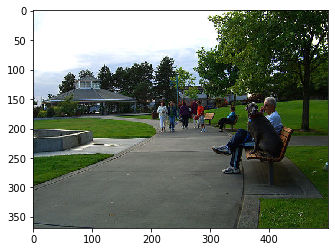

man is standing on the side of the road


In [36]:
generate_caption("42637987_866635edf6.jpg")